In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data, DataLoader

import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler


In [1]:

# Load the dataset
file_path = "jet_data.csv" 
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

# Group the data by event number to inspect jets per event
grouped = df.groupby('event_no')
print(f"Number of unique events: {grouped.ngroups}")


   event_no  jet_no      jet_pt   jet_eta   jet_phi   jet_mass  jet_EbyM  \
0         0       0  168.948030 -1.806623 -2.031107  46.233925  1.160059   
1         0       1  130.779540 -1.273731 -2.969492  19.038677  0.117021   
2         0       2   98.353190 -1.665545  1.773501  13.042610  0.368782   
3         0       3   78.188450 -0.760060  0.281581   9.643224  0.120653   
4         0       4   51.535923 -0.745683  1.732738   8.544092  0.000000   

   signal_or_background  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
Number of unique events: 10000


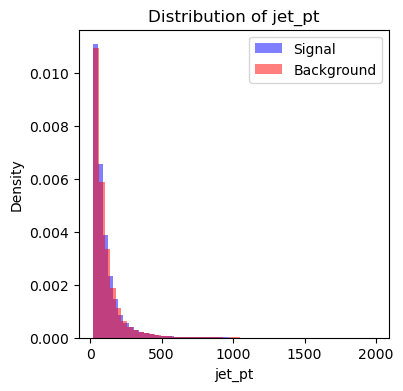

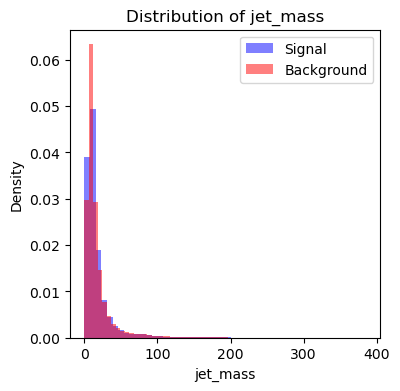

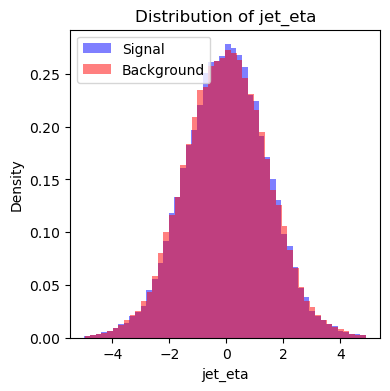

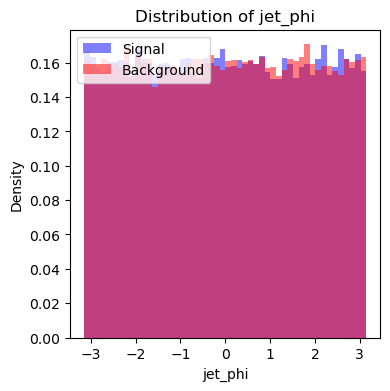

In [4]:
# Load the dataset
file_path = "jet_data.csv" 
df = pd.read_csv(file_path)

# Separate signal and background events
signal = df[df['signal_or_background'] == 1]
background = df[df['signal_or_background'] == 0]

# Plot histograms for key features
features = ['jet_pt', 'jet_mass', 'jet_eta', 'jet_phi']
for feature in features:
    plt.figure(figsize=(4, 4))
    plt.hist(signal[feature], bins=50, alpha=0.5, label="Signal", color='blue', density=True)
    plt.hist(background[feature], bins=50, alpha=0.5, label="Background", color='red', density=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [20]:

# Construct a graph for one event with scaling
def construct_graph_with_scaling(event_data, delta_r_threshold=0.8):
    # Scale features using Min-Max Scaling
    scaler = MinMaxScaler()
    scaled_data = event_data.copy()
    scaled_data[["jet_pt", "jet_eta", "jet_phi", "jet_mass"]] = scaler.fit_transform(
        event_data[["jet_pt", "jet_eta", "jet_phi", "jet_mass"]]
    )
    
    # Create the graph
    G = nx.Graph()
    for idx, row in scaled_data.iterrows():
        G.add_node(idx, pt=row["jet_pt"], eta=row["jet_eta"], phi=row["jet_phi"], mass=row["jet_mass"])
    
    # Add edges based on scaled ΔR
    nodes = list(scaled_data.index)
    for i, j in combinations(nodes, 2):
        jet1 = scaled_data.loc[i]
        jet2 = scaled_data.loc[j]
        delta_eta = jet1["jet_eta"] - jet2["jet_eta"]
        delta_phi = np.abs(jet1["jet_phi"] - jet2["jet_phi"])
        if delta_phi > np.pi:
            delta_phi = 2 * np.pi - delta_phi
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        print(f"Edge check: Nodes {i} and {j}, Scaled ΔR = {delta_r}")
        if delta_r < delta_r_threshold:
            print(f"Adding edge: Nodes {i} and {j}, Scaled ΔR = {delta_r}")
            G.add_edge(i, j, delta_r=delta_r)
    return G


Edge check: Nodes 46010 and 46011, Scaled ΔR = 1.0020453901149693
Edge check: Nodes 46010 and 46012, Scaled ΔR = 0.9324813527476454
Adding edge: Nodes 46010 and 46012, Scaled ΔR = 0.9324813527476454
Edge check: Nodes 46010 and 46013, Scaled ΔR = 0.2303853015118312
Adding edge: Nodes 46010 and 46013, Scaled ΔR = 0.2303853015118312
Edge check: Nodes 46010 and 46014, Scaled ΔR = 0.5828862411080343
Adding edge: Nodes 46010 and 46014, Scaled ΔR = 0.5828862411080343
Edge check: Nodes 46010 and 46015, Scaled ΔR = 0.7293484357001955
Adding edge: Nodes 46010 and 46015, Scaled ΔR = 0.7293484357001955
Edge check: Nodes 46011 and 46012, Scaled ΔR = 0.8867275683571206
Adding edge: Nodes 46011 and 46012, Scaled ΔR = 0.8867275683571206
Edge check: Nodes 46011 and 46013, Scaled ΔR = 0.9422788737961978
Adding edge: Nodes 46011 and 46013, Scaled ΔR = 0.9422788737961978
Edge check: Nodes 46011 and 46014, Scaled ΔR = 0.49311930509273894
Adding edge: Nodes 46011 and 46014, Scaled ΔR = 0.49311930509273894
E

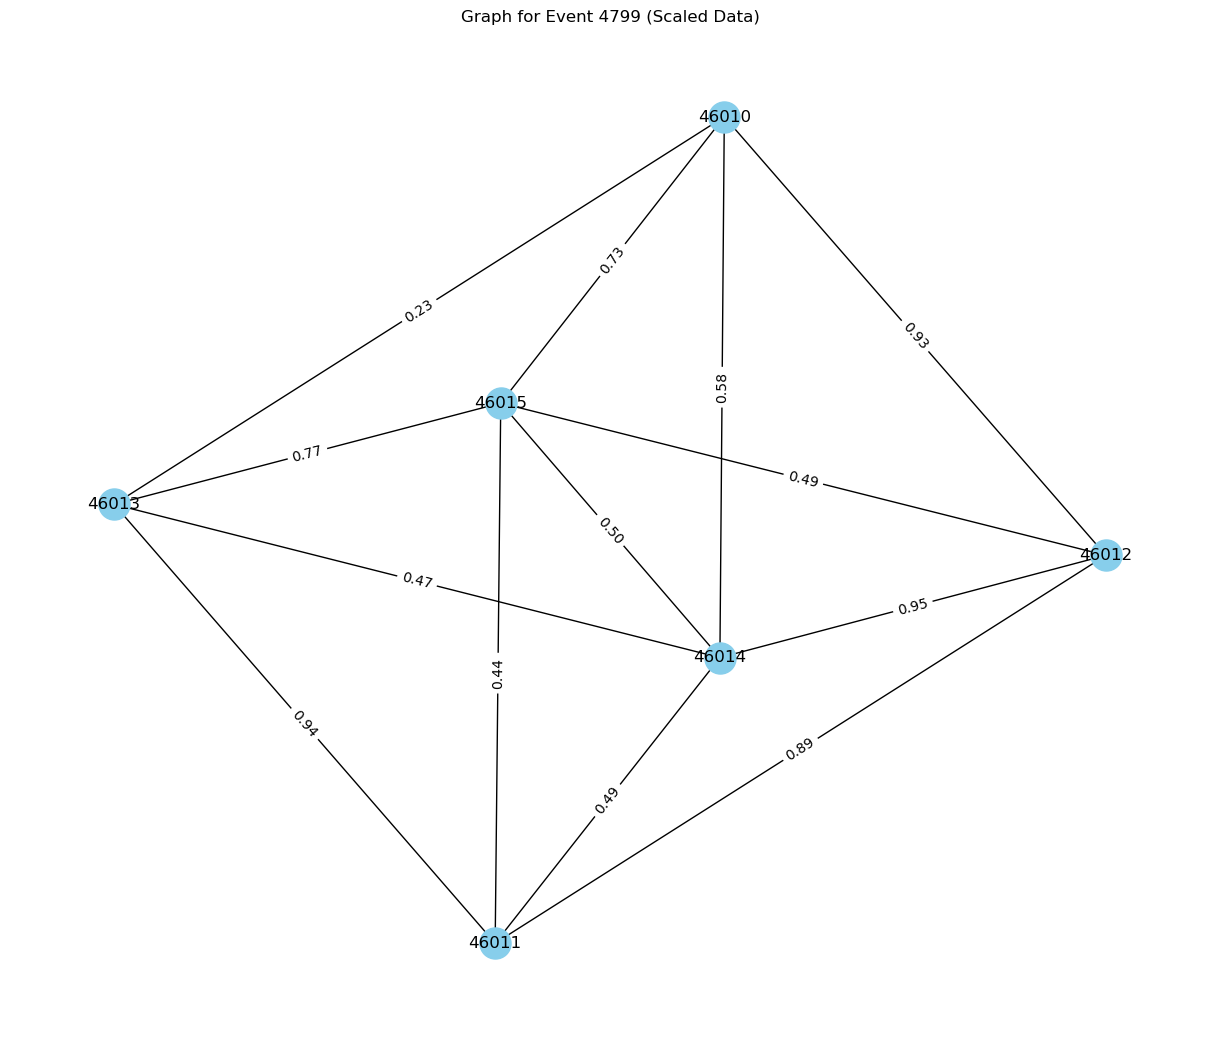

In [21]:
# Select one event
event_no = 4799  # Replace with your event number
event_data = grouped.get_group(event_no).head(10)  # Limit to 10 jets for simplicity

# Construct the graph with scaling
graph = construct_graph_with_scaling(event_data, delta_r_threshold=1.0)

# Visualize the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(graph, k=0.2, iterations=50)
nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=12)
nx.draw_networkx_edge_labels(graph, pos, edge_labels={(i, j): f"{d['delta_r']:.2f}" for i, j, d in graph.edges(data=True)})
plt.title(f"Graph for Event {event_no} (Scaled Data)")
plt.axis("off")
plt.show()


/home/sandeep-sharma/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100 - Loss: 353.8963, Accuracy: 59.89%
Epoch 11/100 - Loss: 54.3179, Accuracy: 52.32%
Epoch 21/100 - Loss: 12.4419, Accuracy: 59.22%
Epoch 31/100 - Loss: 16.8391, Accuracy: 57.98%
Epoch 41/100 - Loss: 6.8950, Accuracy: 64.25%
Epoch 51/100 - Loss: 5.6679, Accuracy: 63.29%
Epoch 61/100 - Loss: 2.2220, Accuracy: 66.60%
Epoch 71/100 - Loss: 1.5836, Accuracy: 65.95%
Epoch 81/100 - Loss: 1.2055, Accuracy: 67.01%
Epoch 91/100 - Loss: 0.8138, Accuracy: 69.40%


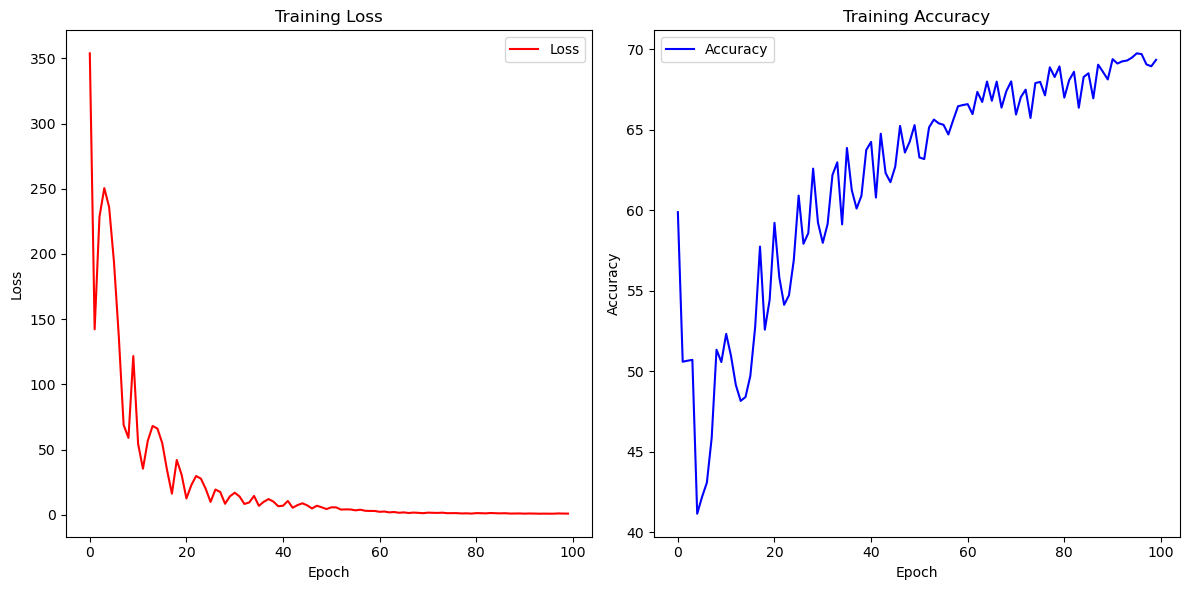

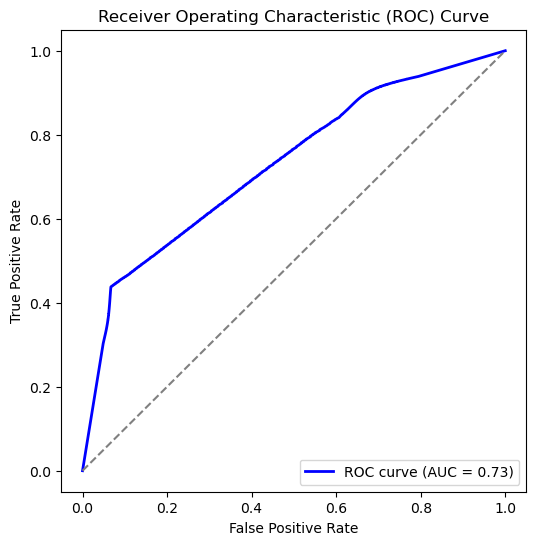

In [ ]:
# Convert DataFrame to PyTorch tensors
inputs = torch.tensor(df.drop('signal_or_background', axis=1).values, dtype=torch.float32)
labels = torch.tensor(df['signal_or_background'].values, dtype=torch.long)

# KNN - Use k-nearest neighbors to define edges based on feature similarity (instead of fully connected)
def create_knn_edges(inputs, k=10):
    nn_model = NearestNeighbors(n_neighbors=k)
    nn_model.fit(inputs)
    distances, indices = nn_model.kneighbors(inputs)
    
    edge_index = []
    for i in range(len(inputs)):
        for j in indices[i][1:]:  # Skip the first neighbor (it's the node itself)
            edge_index.append([i, j])
    
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Generate the graph's edge_index based on KNN
edge_index = create_knn_edges(inputs)

# Define the Graph Neural Network Model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=8, dropout=0.6)
        self.gat2 = GATConv(hidden_dim * 8, output_dim, dropout=0.6)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x

# Prepare the data in PyTorch Geometric format
data = Data(x=inputs, edge_index=edge_index, y=labels)

# Create a DataLoader for batching
batch_size = 32
train_loader = DataLoader([data], batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
input_dim = inputs.shape[1]  # Number of features per jet
hidden_dim = 64  # Hidden layer dimension
output_dim = 2  # Binary classification (signal or background)

model = GNNModel(input_dim, hidden_dim, output_dim)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 100
train_losses = []
train_accuracies = []
y_true = []
y_pred = []

# Train in batches
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Batch-wise training
    for batch_data in train_loader:
        out = model(batch_data)  # Forward pass
        loss = loss_function(out, batch_data.y)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimizer step
        
        # Calculate accuracy
        _, predicted = torch.max(out, 1)
        accuracy = (predicted == batch_data.y).sum().item() / batch_data.y.size(0) * 100
        
        train_losses.append(loss.item())
        train_accuracies.append(accuracy)
        
        # Collect true labels and predicted scores for ROC curve
        y_true.extend(batch_data.y.cpu().numpy())
        y_pred.extend(F.softmax(out, dim=1)[:, 1].detach().cpu().numpy())  # Probabilities for class 1 (signal)
    if epoch%10==0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

# Plot training loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
